# Spectrum simulation with Gammapy

## Introduction

This notebook explains how to use the functions and classes in [gammapy.spectrum](https://docs.gammapy.org/dev/spectrum/index.html) in order to simulate and fit spectra.

First, we will simulate and fit a pure power law without any background. Than we will add a power law shaped background component. Finally, we will see how to simulate and fit a user defined model. For all scenarios a toy detector will be simulated. For an example using real CTA IRFs, checkout [this notebook](https://github.com/gammapy/gammapy/blob/master/tutorials/spectrum_simulation_cta.ipynb).

The following clases will be used:

* [gammapy.irf.EffectiveAreaTable](https://docs.gammapy.org/dev/api/gammapy.irf.EffectiveAreaTable.html)
* [gammapy.irf.EnergyDispersion](https://docs.gammapy.org/dev/api/gammapy.irf.EnergyDispersion)
* [gammapy.spectrum.SpectrumObservation](https://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumObservation.html)
* [gammapy.spectrum.SpectrumSimulation](https://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumSimulation.html)
* [gammapy.spectrum.SpectrumFit](https://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumFit.html)
* [gammapy.spectrum.models.PowerLaw](https://docs.gammapy.org/dev/api/gammapy.spectrum.models.PowerLaw.html)

## Setup

Same procedure as in every script ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from gammapy.irf import EnergyDispersion, EffectiveAreaTable
from gammapy.spectrum import SpectrumSimulation, SpectrumFit
from gammapy.spectrum.models import PowerLaw

## Create detector

For the sake of self consistency of this tutorial, we will simulate a simple detector. For a real application you would want to replace this part of the code with loading the IRFs or your detector.

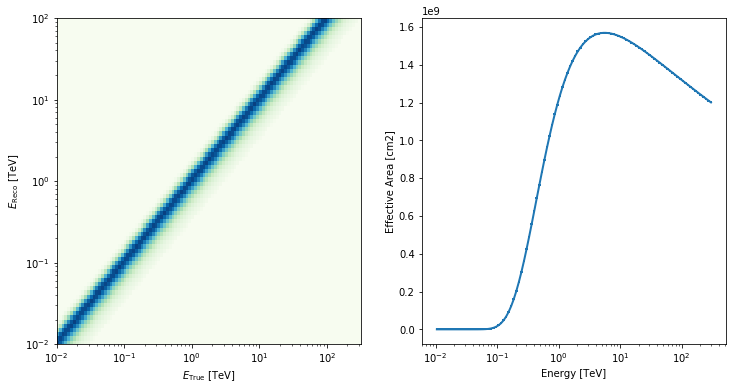

In [3]:
e_true = np.logspace(-2, 2.5, 109) * u.TeV
e_reco = np.logspace(-2, 2, 79) * u.TeV

edisp = EnergyDispersion.from_gauss(
    e_true=e_true, e_reco=e_reco, sigma=0.2, bias=0
)
aeff = EffectiveAreaTable.from_parametrization(energy=e_true)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
edisp.plot_matrix(ax=axes[0])
aeff.plot(ax=axes[1]);

## Power law

In this section we will simulate one observation using a power law model.

In [4]:
pwl = PowerLaw(
    index=2.3, amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
print(pwl)

PowerLaw

Parameters: 

	   name     value   error      unit      min max frozen
	--------- --------- ----- -------------- --- --- ------
	    index 2.300e+00   nan                nan nan  False
	amplitude 1.000e-11   nan cm-2 s-1 TeV-1 nan nan  False
	reference 1.000e+00   nan            TeV nan nan   True


In [5]:
livetime = 2 * u.h
sim = SpectrumSimulation(
    aeff=aeff, edisp=edisp, source_model=pwl, livetime=livetime
)
sim.simulate_obs(seed=2309, obs_id=1)
print(sim.obs)

*** Observation summary report ***
Observation Id: 1
Livetime: 2.000 h
On events: 339
Off events: 0
Alpha: 1.000
Bkg events in On region: 0.00
Excess: 339.00
Gamma rate: 2.83 1 / min
Bkg rate: 0.00 1 / min
Sigma: nan
energy range: 0.01 TeV - 100.00 TeV


In [6]:
fit = SpectrumFit(obs_list=sim.obs, model=pwl.copy(), stat="cash")
fit.fit_range = [1, 10] * u.TeV
fit.run()
print(fit.result[0])


Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error        unit      min max frozen
	--------- --------- --------- -------------- --- --- ------
	    index 2.259e+00 2.191e-01                nan nan  False
	amplitude 9.255e-12 1.754e-12 cm-2 s-1 TeV-1 nan nan  False
	reference 1.000e+00 0.000e+00            TeV nan nan   True

Covariance: 

	   name     index   amplitude reference
	--------- --------- --------- ---------
	    index 4.802e-02 2.984e-13 0.000e+00
	amplitude 2.984e-13 3.077e-24 0.000e+00
	reference 0.000e+00 0.000e+00 0.000e+00 

Statistic: -74.059 (cash)
Fit Range: [1.         9.42668455] TeV



## Include background

In this section we will include a background component. Furthermore, we will also simulate more than one observation and fit each one individuallt in order to get average fit results.

In [7]:
bkg_model = PowerLaw(
    index=2.5, amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)

In [8]:
%%time
n_obs = 30
seeds = np.arange(n_obs)

sim = SpectrumSimulation(
    aeff=aeff,
    edisp=edisp,
    source_model=pwl,
    livetime=livetime,
    background_model=bkg_model,
    alpha=0.2,
)

sim.run(seeds)
print(sim.result)
print(sim.result[0])

SpectrumObservationList
Number of observations: 30
*** Observation summary report ***
Observation Id: 0
Livetime: 2.000 h
On events: 733
Off events: 1915
Alpha: 0.200
Bkg events in On region: 383.00
Excess: 350.00
Excess / Background: 0.91
Gamma rate: 2.92 1 / min
Bkg rate: 0.04 1 / min
Sigma: 14.17
energy range: 0.01 TeV - 100.00 TeV
CPU times: user 306 ms, sys: 5.72 ms, total: 311 ms
Wall time: 155 ms


Before moving on to the fit let's have a look at the simulated observations

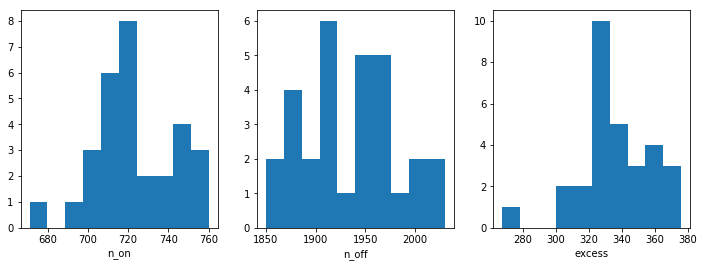

In [9]:
n_on = [obs.total_stats.n_on for obs in sim.result]
n_off = [obs.total_stats.n_off for obs in sim.result]
excess = [obs.total_stats.excess for obs in sim.result]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("n_on")
axes[1].hist(n_off)
axes[1].set_xlabel("n_off")
axes[2].hist(excess)
axes[2].set_xlabel("excess");

In [10]:
%%time
results = []
for obs in sim.result:
    fit = SpectrumFit(obs, pwl.copy(), stat="wstat")
    fit.optimize()
    results.append(
        {
            "index": fit.result[0].model.parameters["index"].value,
            "amplitude": fit.result[0].model.parameters["amplitude"].value,
        }
    )

CPU times: user 2.78 s, sys: 9.51 ms, total: 2.79 s
Wall time: 1.4 s


spectral index: 2.31 +/- 0.09


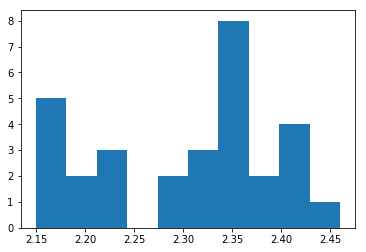

In [11]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10)
print("spectral index: {:.2f} +/- {:.2f}".format(index.mean(), index.std()))

## Exercises

* Fit a pure power law and the user define model to the observation you just simulated. You can start with the user defined model described in the [spectrum_models.ipynb](https://github.com/gammapy/gammapy/blob/master/tutorials/spectrum_models.ipynb) notebook.
* Vary the observation lifetime and see when you can distinguish the two models (Hint: You get the final likelihood of a fit from `fit.result[0].statval`).

## What's next

In this tutorial we learnd how to simulate and fit data using a toy detector. Go to [gammapy.spectrum](https://docs.gammapy.org/dev/spectrum/index.html) to see what else you can do with gammapy.